#**Blending - XgBoost (Classification)**

**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.decomposition import PCA

**Code**

In [2]:
# Load the iris dataset (for classification)
data = load_iris()
X, y = data.data, data.target

In [3]:
# Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Further split the training set into train and validation sets (for blending)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [5]:
# Define base classifiers
base_classifiers = [
    ('xgb', XGBClassifier(n_estimators=50, random_state=42, eval_metric='mlogloss')),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('adaboost', AdaBoostClassifier(n_estimators=50, random_state=42)),
]

In [6]:
# Step 1: Train base classifiers on the training set
val_predictions = np.zeros((X_val.shape[0], len(base_classifiers)))  # Placeholder for validation predictions
test_predictions = np.zeros((X_test.shape[0], len(base_classifiers)))  # Placeholder for test set predictions
fitted_classifiers = []  # To store fitted classifier instances

for i, (name, clf) in enumerate(base_classifiers):
    # Clone the classifier to avoid overwriting during blending
    clf_instance = clone(clf)

    # Train on the full training set
    clf_instance.fit(X_train, y_train)
    fitted_classifiers.append(clf_instance)  # Store the fitted instance

    # Store predictions on the validation set (for blending)
    val_predictions[:, i] = clf_instance.predict(X_val)

    # Store predictions on the test set
    test_predictions[:, i] = clf_instance.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [7]:
# Step 2: Blend predictions using Logistic Regression
blender = LogisticRegression()
blender.fit(val_predictions, y_val)

LogisticRegression()

In [8]:
# Step 3: Make final predictions on the test set using the blender
final_predictions = blender.predict(test_predictions)

In [9]:
# Calculate and display the accuracy of the blended model
blended_accuracy = accuracy_score(y_test, final_predictions)
print(f'Blended Model Accuracy: {blended_accuracy:.2f}')

Blended Model Accuracy: 1.00


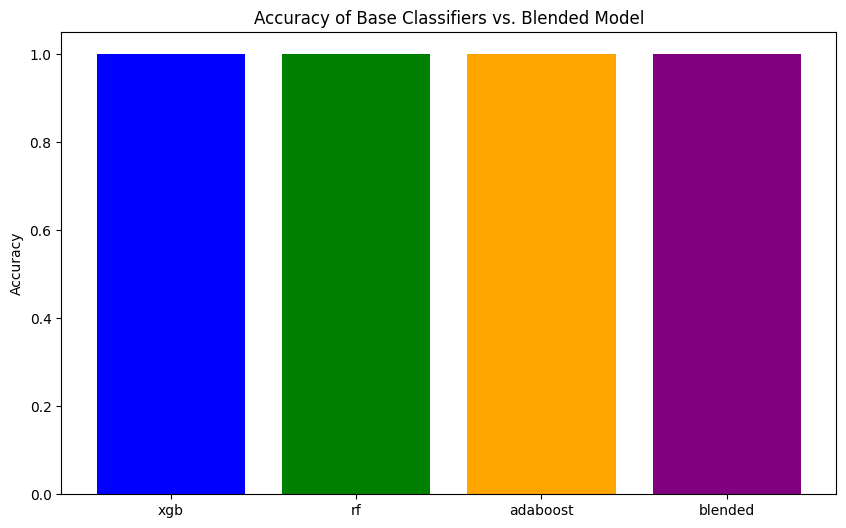

In [10]:
# Visualize individual classifier accuracy and blended model accuracy
individual_accuracies = []

for clf_instance, (name, _) in zip(fitted_classifiers, base_classifiers):
    clf_pred = clf_instance.predict(X_test)
    acc = accuracy_score(y_test, clf_pred)
    individual_accuracies.append((name, acc))

# Plot individual classifier accuracy vs. blended model accuracy
names, accuracies = zip(*individual_accuracies)
plt.figure(figsize=(10, 6))
plt.bar(names + ('blended',), accuracies + (blended_accuracy,), color=['blue', 'green', 'orange', 'purple'])
plt.ylabel('Accuracy')
plt.title('Accuracy of Base Classifiers vs. Blended Model')
plt.show()

In [11]:
# Apply PCA to reduce the dimensions to 2 for visualization (Optional)
pca = PCA(n_components=2)
test_predictions_2d = pca.fit_transform(test_predictions)

In [12]:
# Train a logistic regression model on the PCA-transformed data for visualization
blender_pca = LogisticRegression()
blender_pca.fit(test_predictions_2d, y_test)

LogisticRegression()

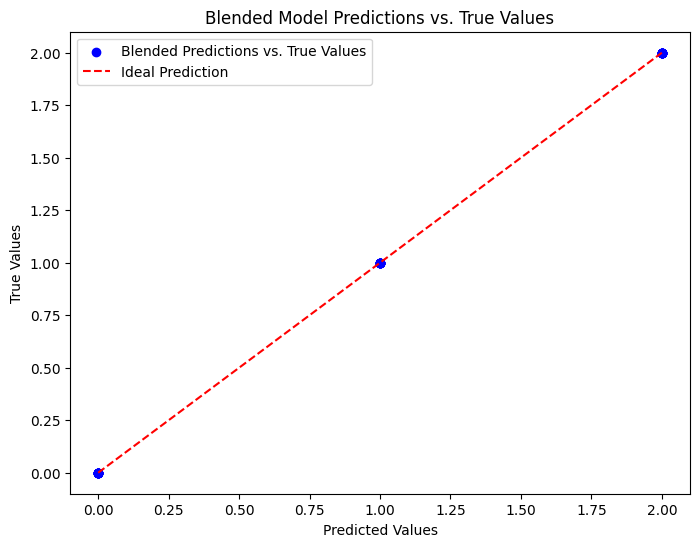

In [13]:
# Scatter plot for blended predictions vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(final_predictions, y_test, color='blue', label='Blended Predictions vs. True Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.legend()
plt.title('Blended Model Predictions vs. True Values')
plt.show()